# Reflexion

[Reflexion](https://arxiv.org/abs/2303.11366) by Shinn, et. al., is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its responses for tasks to generate a higher quality final response, at the expense of longer execution time.

![reflexion diagram](https://github.com/langchain-ai/langgraph/blob/main/examples/reflexion/img/reflexion.png)

The paper outlines 3 main components:

1. Actor (agent) with self-reflection
2. External evaluator (task-specific, e.g. code compilation steps)
3. Episodic memory that stores the reflections from (1).

In their code, the last two components are very task-specific, so in this notebook, you will build the _actor_ in LangGraph.

To skip to the graph definition, see the [Construct Graph section](#Construct-Graph) below.

## 0. Prerequisites

Install `langgraph` (for the framework), `langchain_openai` (for the LLM), and `langchain` + `tavily-python` (for the search engine).

We will use tavily search as a tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a different tool of your choosing.

In [1]:
from dotenv import load_dotenv
load_dotenv("../../.env", verbose=True)

from loguru import logger
logger.add('./reflexion.log')

1

In [2]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


# Optional: Configure tracing to visualize and debug the agent
# _set_if_undefined("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agent_Reflexion"

# _set_if_undefined("ANTHROPIC_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

In [3]:
# from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(model="claude-3-sonnet-20240229")
# You could also use OpenAI or another provider
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-turbo-preview")

## 1. Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:
1. Tools/tool execution
2. Initial responder: generate an initial response (and self-reflection)
3. Revisor: re-respond (and reflec) based on previous reflections

We'll first define the tool execution context.

#### Construct tools

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

#### Initial responder

In [5]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

In [6]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [7]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond([HumanMessage(content=example_question)])
logger.debug(initial.pretty_repr())


2024-08-04 00:37:18.759 | DEBUG    | __main__:<module>:3 - ================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_8VFhKFpqDDMBvFGjgp9Fl8cK)
 Call ID: call_8VFhKFpqDDMBvFGjgp9Fl8cK
  Args:
    answer: Reflection is a crucial aspect of AI for several reasons. Firstly, it enables self-improvement. By reflecting on past actions, decisions, and outcomes, an AI system can identify what worked well and what didn't, thereby refining its algorithms and decision-making processes. This iterative learning process is fundamental for developing more accurate and efficient models. Secondly, reflection helps in error detection and correction. By reviewing its own performance, an AI can spot mistakes or biases in its functioning, which can then be addressed to enhance reliability and fairness. Thirdly, reflection aids in transparency and explainability. In complex AI systems, understanding the rationale behind certain decisions can be challen

#### Revision

The second part of the actor is a revision step.

In [8]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [9]:
initial.tool_calls[0]["args"]

{'answer': "Reflection is a crucial aspect of AI for several reasons. Firstly, it enables self-improvement. By reflecting on past actions, decisions, and outcomes, an AI system can identify what worked well and what didn't, thereby refining its algorithms and decision-making processes. This iterative learning process is fundamental for developing more accurate and efficient models. Secondly, reflection helps in error detection and correction. By reviewing its own performance, an AI can spot mistakes or biases in its functioning, which can then be addressed to enhance reliability and fairness. Thirdly, reflection aids in transparency and explainability. In complex AI systems, understanding the rationale behind certain decisions can be challenging. Reflective processes can help elucidate the internal workings of the AI, making it easier for humans to comprehend and trust its operations. Lastly, reflection supports adaptability. In dynamic environments where conditions and requirements co

In [10]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                tavily_tool.invoke(
                    {"query": initial.tool_calls[0]["args"]["search_queries"][0]}
                )
            ),
        ),
    ]
)


2024-08-04 00:41:19.987 | DEBUG    | __main__:<module>:17 - content='' additional_kwargs={'tool_calls': [{'id': 'call_dBsVLeqcE1qIlWGq8PWtbfKN', 'function': {'arguments': '{"answer": "Reflection is a crucial aspect of AI for several reasons. Firstly, it enables self-improvement. By reflecting on past actions, decisions, and outcomes, an AI system can identify what worked well and what didn\'t, thereby refining its algorithms and decision-making processes. This iterative learning process is fundamental for developing more accurate and efficient models. Secondly, reflection helps in error detection and correction. By reviewing its own performance, an AI can spot mistakes or biases in its functioning, which can then be addressed to enhance reliability and fairness. Thirdly, reflection aids in transparency and explainability. In complex AI systems, understanding the rationale behind certain decisions can be challenging. Reflective processes can help elucidate the internal workings of the A

In [11]:
logger.debug(revised.pretty_repr())

2024-08-04 00:42:19.326 | DEBUG    | __main__:<module>:1 - ================================== Ai Message ==================================
Tool Calls:
  ReviseAnswer (call_dBsVLeqcE1qIlWGq8PWtbfKN)
 Call ID: call_dBsVLeqcE1qIlWGq8PWtbfKN
  Args:
    answer: Reflection is a crucial aspect of AI for several reasons. Firstly, it enables self-improvement. By reflecting on past actions, decisions, and outcomes, an AI system can identify what worked well and what didn't, thereby refining its algorithms and decision-making processes. This iterative learning process is fundamental for developing more accurate and efficient models. Secondly, reflection helps in error detection and correction. By reviewing its own performance, an AI can spot mistakes or biases in its functioning, which can then be addressed to enhance reliability and fairness. Thirdly, reflection aids in transparency and explainability. In complex AI systems, understanding the rationale behind certain decisions can be challengi

## Create Tool Node

Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool.

In [12]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

## Construct Graph


Now we can wire all our components together.

In [13]:
from typing import Literal

from langgraph.graph import END, MessageGraph, START

MAX_ITERATIONS = 5
builder = MessageGraph()
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

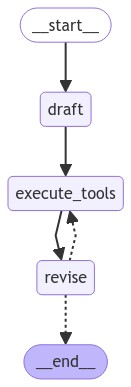

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
events = graph.stream(
    [HumanMessage(content="How should we handle the climate crisis?")],
    stream_mode="values",
)
for i, step in enumerate(events):
    logger.info(f"Step {i}")
    logger.debug(step[-1].pretty_repr())

2024-08-04 00:43:21.402 | INFO     | __main__:<module>:6 - Step 0
2024-08-04 00:43:21.403 | DEBUG    | __main__:<module>:7 - ================================ Human Message =================================

How should we handle the climate crisis?
2024-08-04 00:43:45.033 | INFO     | __main__:<module>:6 - Step 1
2024-08-04 00:43:45.035 | DEBUG    | __main__:<module>:7 - ================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_MfKa4iFYXva9f1RpraTODbgR)
 Call ID: call_MfKa4iFYXva9f1RpraTODbgR
  Args:
    answer: Addressing the climate crisis requires a multifaceted approach that involves coordinated efforts at the individual, community, national, and global levels. Here are some key strategies to handle the climate crisis effectively:

1. **Policy and Governance**: Governments must implement strong climate policies that promote renewable energy, energy efficiency, and sustainable practices. This includes setting ambitious targets

ValidationError: 1 validation error for AnswerQuestionSchema
search_queries
  field required (type=value_error.missing)

## Conclusion

Congrats on building a Reflexion actor! I'll leave you with a few observations to save you some time when choosing which parts of this agent to adapt to your workflow:
1. This agent trades off execution time for quality. It explicitly forces the agent to critique and revise the output over several steps, which usually (not always) increases the response quality but takes much longer to return a final answer
2. The 'reflections' can be paired with additional external feedback (such as validators), to further guide the actor.
3. In the paper, 1 environment (AlfWorld) uses external memory. It does this by storing summaries of the reflections to an external store and using them in subsequent trials/invocations.